# 2026-01-05 lgbm+baseline

In [14]:
# ==========================================
# Global model (LGBM) + Baselines (NO FILE OUTPUT)
# Target week: 2026-01-05
# Predict:
#   - trip_cnt_per_user
#   - nonrepeat_cnt_per_user
# ==========================================

import numpy as np
import pandas as pd

# --------------------------
# Config
# --------------------------
DATA_PATH = "../../final_data/data_260119_random.csv"   # 改成你本機路徑也可以
TARGET_WEEK = "2026-01-05"

CAT_COLS = ["treatment", "source", "ops_type_merged", "city_group"]
DATE_COL = "experiment_date"

Y1 = "trip_cnt_per_user"
Y2 = "nonrepeat_cnt_per_user"

# Baselines (必須在資料裡存在)
Y1_LAG1 = "trip_cnt_per_user_lag1"
Y1_ROLL4 = "trip_cnt_per_user_roll4"
Y2_LAG1 = "nonrepeat_cnt_per_user_lag1"
Y2_ROLL4 = "nonrepeat_cnt_per_user_roll4"

RANDOM_STATE = 42

# --------------------------
# Helpers
# --------------------------
def rmse(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    return float(np.sqrt(np.mean((y_true - y_pred) ** 2)))

def mae(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    return float(np.mean(np.abs(y_true - y_pred)))

def make_time_val_split(train_df, date_col, n_val_weeks=4):
    """
    用 train 資料中最後 n_val_weeks 個 unique 週當 validation（時間切分）
    """
    uniq_dates = np.array(sorted(pd.to_datetime(train_df[date_col]).dt.date.unique()))
    if len(uniq_dates) <= 2:
        return train_df.copy(), None

    n_val_weeks = min(n_val_weeks, max(1, len(uniq_dates) // 5))
    val_dates = set(uniq_dates[-n_val_weeks:])

    tr = train_df[~pd.to_datetime(train_df[date_col]).dt.date.isin(val_dates)].copy()
    va = train_df[pd.to_datetime(train_df[date_col]).dt.date.isin(val_dates)].copy()

    # fallback：若切不到就改 80/20 by date
    if tr.empty or va.empty:
        cut = int(len(uniq_dates) * 0.8)
        cut = max(1, min(cut, len(uniq_dates) - 1))
        tr_dates = set(uniq_dates[:cut])
        va_dates = set(uniq_dates[cut:])
        tr = train_df[pd.to_datetime(train_df[date_col]).dt.date.isin(tr_dates)].copy()
        va = train_df[pd.to_datetime(train_df[date_col]).dt.date.isin(va_dates)].copy()
        if tr.empty or va.empty:
            return train_df.copy(), None

    return tr, va

# --------------------------
# Load & preprocess
# --------------------------
df = pd.read_csv(DATA_PATH)
df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors="coerce")

if df[DATE_COL].isna().any():
    bad = df[df[DATE_COL].isna()].head(10)
    raise ValueError(f"Found unparsable dates in {DATE_COL}. Examples:\n{bad}")

required_cols = CAT_COLS + [DATE_COL, Y1, Y2, Y1_LAG1, Y1_ROLL4, Y2_LAG1, Y2_ROLL4]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}")

for c in CAT_COLS:
    df[c] = df[c].astype("category")

# 用 week_idx 取代把日期直接丟進模型（比較穩）
min_date = df[DATE_COL].min()
df["week_idx"] = ((df[DATE_COL] - min_date).dt.days // 7).astype(int)

target_week = pd.to_datetime(TARGET_WEEK)

# --------------------------
# Split train / test (time-based)
# --------------------------
train = df[df[DATE_COL] < target_week].copy()
test = df[df[DATE_COL] == target_week].copy()

if train.empty:
    raise ValueError("Train set is empty. TARGET_WEEK may be too early.")
if test.empty:
    raise ValueError(f"Test set is empty for week {TARGET_WEEK}. Check experiment_date values.")

print("=== Target week ===", TARGET_WEEK)
print("Train rows:", len(train), "| Test rows:", len(test))
print("Train weeks:", train[DATE_COL].dt.date.nunique(), "| Test weeks:", test[DATE_COL].dt.date.nunique())
print("Test ops_type_merged:", test["ops_type_merged"].nunique())

# --------------------------
# Baseline predictions (直接用 lag/roll 當預測)
# --------------------------
test["pred_y1_lag1"] = test[Y1_LAG1].astype(float)
test["pred_y1_roll4"] = test[Y1_ROLL4].astype(float)
test["pred_y2_lag1"] = test[Y2_LAG1].astype(float)
test["pred_y2_roll4"] = test[Y2_ROLL4].astype(float)

# --------------------------
# Feature matrix: 用「除了 y 以外」全部欄位當特徵
# 並把 experiment_date 拿掉（保留 week_idx）
# --------------------------
exclude = {Y1, Y2}
feature_cols = [c for c in df.columns if c not in exclude]
if DATE_COL in feature_cols:
    feature_cols.remove(DATE_COL)

cat_features = [c for c in CAT_COLS if c in feature_cols]

X_train = train[feature_cols].copy()
X_test = test[feature_cols].copy()

y1_train = train[Y1].astype(float).values
y2_train = train[Y2].astype(float).values

y1_true = test[Y1].astype(float).values
y2_true = test[Y2].astype(float).values

# --------------------------
# Time-based validation for early stopping
# --------------------------
tr_df, va_df = make_time_val_split(train, DATE_COL, n_val_weeks=4)
X_tr = tr_df[feature_cols].copy()
y1_tr = tr_df[Y1].astype(float).values
y2_tr = tr_df[Y2].astype(float).values

X_va = y1_va = y2_va = None
if va_df is not None:
    X_va = va_df[feature_cols].copy()
    y1_va = va_df[Y1].astype(float).values
    y2_va = va_df[Y2].astype(float).values

# --------------------------
# Train LGBM (global) — 兩個 target 各一個模型
# --------------------------
import lightgbm as lgb

common_params = dict(
    objective="regression",
    n_estimators=2000,
    learning_rate=0.05,
    num_leaves=63,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RANDOM_STATE,
    force_row_wise=True,   # 加速/避免 overhead 測試
)

m_y1 = lgb.LGBMRegressor(**common_params)
m_y2 = lgb.LGBMRegressor(**common_params)

fit_kwargs = dict(categorical_feature=cat_features)

if X_va is not None:
    m_y1.fit(
        X_tr, y1_tr,
        eval_set=[(X_va, y1_va)],
        eval_metric="l2",
        callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=False)],
        **fit_kwargs
    )
    m_y2.fit(
        X_tr, y2_tr,
        eval_set=[(X_va, y2_va)],
        eval_metric="l2",
        callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=False)],
        **fit_kwargs
    )
else:
    m_y1.fit(X_train, y1_train, **fit_kwargs)
    m_y2.fit(X_train, y2_train, **fit_kwargs)

# Predict on target week
test["pred_y1_lgbm"] = m_y1.predict(X_test)
test["pred_y2_lgbm"] = m_y2.predict(X_test)

# --------------------------
# Overall metrics
# --------------------------
metrics_df = pd.DataFrame([
    {"target": Y1, "model": "baseline_lag1",  "MAE": mae(y1_true, test["pred_y1_lag1"]),  "RMSE": rmse(y1_true, test["pred_y1_lag1"])},
    {"target": Y1, "model": "baseline_roll4", "MAE": mae(y1_true, test["pred_y1_roll4"]), "RMSE": rmse(y1_true, test["pred_y1_roll4"])},
    {"target": Y1, "model": "lgbm_global",    "MAE": mae(y1_true, test["pred_y1_lgbm"]),  "RMSE": rmse(y1_true, test["pred_y1_lgbm"])},

    {"target": Y2, "model": "baseline_lag1",  "MAE": mae(y2_true, test["pred_y2_lag1"]),  "RMSE": rmse(y2_true, test["pred_y2_lag1"])},
    {"target": Y2, "model": "baseline_roll4", "MAE": mae(y2_true, test["pred_y2_roll4"]), "RMSE": rmse(y2_true, test["pred_y2_roll4"])},
    {"target": Y2, "model": "lgbm_global",    "MAE": mae(y2_true, test["pred_y2_lgbm"]),  "RMSE": rmse(y2_true, test["pred_y2_lgbm"])},
]).sort_values(["target", "model"]).reset_index(drop=True)

print("\n=== Overall metrics (target week) ===")
print(metrics_df.to_string(index=False))

# --------------------------
# Metrics by ops_type_merged (diagnostic)
# --------------------------
rows = []
for ops, g in test.groupby("ops_type_merged"):
    y1g = g[Y1].astype(float).values
    y2g = g[Y2].astype(float).values
    rows += [
        {"ops_type_merged": ops, "target": Y1, "model": "baseline_lag1",  "MAE": mae(y1g, g["pred_y1_lag1"]),  "RMSE": rmse(y1g, g["pred_y1_lag1"]),  "n": len(g)},
        {"ops_type_merged": ops, "target": Y1, "model": "baseline_roll4", "MAE": mae(y1g, g["pred_y1_roll4"]), "RMSE": rmse(y1g, g["pred_y1_roll4"]), "n": len(g)},
        {"ops_type_merged": ops, "target": Y1, "model": "lgbm_global",    "MAE": mae(y1g, g["pred_y1_lgbm"]),  "RMSE": rmse(y1g, g["pred_y1_lgbm"]),  "n": len(g)},

        {"ops_type_merged": ops, "target": Y2, "model": "baseline_lag1",  "MAE": mae(y2g, g["pred_y2_lag1"]),  "RMSE": rmse(y2g, g["pred_y2_lag1"]),  "n": len(g)},
        {"ops_type_merged": ops, "target": Y2, "model": "baseline_roll4", "MAE": mae(y2g, g["pred_y2_roll4"]), "RMSE": rmse(y2g, g["pred_y2_roll4"]), "n": len(g)},
        {"ops_type_merged": ops, "target": Y2, "model": "lgbm_global",    "MAE": mae(y2g, g["pred_y2_lgbm"]),  "RMSE": rmse(y2g, g["pred_y2_lgbm"]),  "n": len(g)},
    ]

metrics_by_ops_df = pd.DataFrame(rows).sort_values(["target","ops_type_merged","model"]).reset_index(drop=True)

print("\n=== Metrics by ops_type_merged (target week) ===")
print(metrics_by_ops_df.to_string(index=False))

# --------------------------
# Prediction preview (first 30 rows)
# --------------------------
id_cols = [DATE_COL, "treatment", "source", "ops_type_merged", "city_group"]
preview_cols = id_cols + [
    Y1, "pred_y1_lag1", "pred_y1_roll4", "pred_y1_lgbm",
    Y2, "pred_y2_lag1", "pred_y2_roll4", "pred_y2_lgbm",
]
print("\n=== Prediction preview (first 30 rows) ===")
print(test[preview_cols].head(30).to_string(index=False))

# --------------------------
# Quick aggregates (means)
# --------------------------
agg = pd.DataFrame({
    "metric": ["mean_true", "mean_pred_lag1", "mean_pred_roll4", "mean_pred_lgbm"],
    "trip_cnt_per_user": [
        float(np.mean(test[Y1])),
        float(np.mean(test["pred_y1_lag1"])),
        float(np.mean(test["pred_y1_roll4"])),
        float(np.mean(test["pred_y1_lgbm"])),
    ],
    "nonrepeat_cnt_per_user": [
        float(np.mean(test[Y2])),
        float(np.mean(test["pred_y2_lag1"])),
        float(np.mean(test["pred_y2_roll4"])),
        float(np.mean(test["pred_y2_lgbm"])),
    ],
})
print("\n=== Quick aggregates (means) ===")
print(agg.to_string(index=False))


=== Target week === 2026-01-05
Train rows: 2112 | Test rows: 192
Train weeks: 13 | Test weeks: 1
Test ops_type_merged: 8
[LightGBM] [Info] Total Bins 12465
[LightGBM] [Info] Number of data points in the train set: 1728, number of used features: 98
[LightGBM] [Info] Start training from score 0.108678
[LightGBM] [Info] Total Bins 12465
[LightGBM] [Info] Number of data points in the train set: 1728, number of used features: 98
[LightGBM] [Info] Start training from score 0.147880

=== Overall metrics (target week) ===
                target          model      MAE     RMSE
nonrepeat_cnt_per_user  baseline_lag1 0.065099 0.086011
nonrepeat_cnt_per_user baseline_roll4 0.052816 0.066204
nonrepeat_cnt_per_user    lgbm_global 0.035945 0.046623
     trip_cnt_per_user  baseline_lag1 0.041854 0.058035
     trip_cnt_per_user baseline_roll4 0.034874 0.045440
     trip_cnt_per_user    lgbm_global 0.028981 0.038853

=== Metrics by ops_type_merged (target week) ===
ops_type_merged                 target

C:\Users\minhsiang.chang\AppData\Local\Temp\ipykernel_18372\607598752.py:218: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for ops, g in test.groupby("ops_type_merged"):


# 近6週backtest

In [ ]:
# ==========================================
# Multi-week rolling backtest (NO FILE OUTPUT)
# Global LGBM vs baselines (lag1 / roll4)
#
# For each target week t:
#   Train = experiment_date < t
#   Validation = last N weeks inside Train (time-based) for early stopping
#   Test = experiment_date == t
#
# Targets:
#   - trip_cnt_per_user
#   - nonrepeat_cnt_per_user
# ==========================================

import numpy as np
import pandas as pd

# --------------------------
# Config
# --------------------------
DATA_PATH = "../../final_data/data_260119_random.csv"
DATE_COL = "experiment_date"

CAT_COLS = ["treatment", "source", "ops_type_merged", "city_group"]

Y1 = "trip_cnt_per_user"
Y2 = "nonrepeat_cnt_per_user"

Y1_LAG1 = "trip_cnt_per_user_lag1"
Y1_ROLL4 = "trip_cnt_per_user_roll4"
Y2_LAG1 = "nonrepeat_cnt_per_user_lag1"
Y2_ROLL4 = "nonrepeat_cnt_per_user_roll4"

# Backtest settings
N_TEST_WEEKS = 8         # 最近幾週要拿來做 backtest（可調大/小）
N_VAL_WEEKS = 4          # early stopping 用的 validation 週數（從 train 最後切）
MIN_TRAIN_WEEKS = 8      # 至少要有幾週 train 才做那週 backtest（避免太早週數不足）

# LGBM settings
RANDOM_STATE = 42
LGBM_PARAMS = dict(
    objective="regression",
    n_estimators=2000,
    learning_rate=0.05,
    num_leaves=63,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RANDOM_STATE,
    force_row_wise=True,
)

EARLY_STOPPING_ROUNDS = 100

# --------------------------
# Helpers
# --------------------------
def rmse(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    return float(np.sqrt(np.mean((y_true - y_pred) ** 2)))

def mae(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    return float(np.mean(np.abs(y_true - y_pred)))

def make_time_val_split(train_df, date_col, n_val_weeks):
    """
    Time-based validation: last n_val_weeks unique dates in train_df as validation.
    Returns: (train_part, val_part) or (train_df, None) if not possible.
    """
    uniq_dates = np.array(sorted(pd.to_datetime(train_df[date_col]).dt.date.unique()))
    if len(uniq_dates) <= 2:
        return train_df.copy(), None

    n_val_weeks = min(n_val_weeks, max(1, len(uniq_dates) // 5))
    val_dates = set(uniq_dates[-n_val_weeks:])

    tr = train_df[~pd.to_datetime(train_df[date_col]).dt.date.isin(val_dates)].copy()
    va = train_df[pd.to_datetime(train_df[date_col]).dt.date.isin(val_dates)].copy()

    if tr.empty or va.empty:
        return train_df.copy(), None

    return tr, va

# --------------------------
# Load & preprocess
# --------------------------
df = pd.read_csv(DATA_PATH)
df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors="coerce")

if df[DATE_COL].isna().any():
    bad = df[df[DATE_COL].isna()].head(10)
    raise ValueError(f"Found unparsable dates in {DATE_COL}. Examples:\n{bad}")

required_cols = CAT_COLS + [DATE_COL, Y1, Y2, Y1_LAG1, Y1_ROLL4, Y2_LAG1, Y2_ROLL4]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}")

for c in CAT_COLS:
    df[c] = df[c].astype("category")

# Use numeric week index instead of raw date as feature
min_date = df[DATE_COL].min()
df["week_idx"] = ((df[DATE_COL] - min_date).dt.days // 7).astype(int)

# Feature columns = everything except targets, and drop raw date
exclude = {Y1, Y2}
feature_cols = [c for c in df.columns if c not in exclude]
if DATE_COL in feature_cols:
    feature_cols.remove(DATE_COL)

cat_features = [c for c in CAT_COLS if c in feature_cols]

# List all available weeks
weeks_all = sorted(df[DATE_COL].dt.date.unique())
if len(weeks_all) < (N_TEST_WEEKS + MIN_TRAIN_WEEKS + 1):
    print(
        f"[Warning] weeks_all={len(weeks_all)} is not large. "
        f"Backtest may skip many early weeks due to MIN_TRAIN_WEEKS={MIN_TRAIN_WEEKS}."
    )

# Choose the last N_TEST_WEEKS as test weeks (you can change this selection logic)
test_weeks = weeks_all[-N_TEST_WEEKS:]

print("=== Backtest weeks (test targets) ===")
print([str(w) for w in test_weeks])

# --------------------------
# Backtest loop
# --------------------------
import lightgbm as lgb

results = []          # overall metrics per week/target/model
results_by_ops = []   # optional: ops_type_merged metrics per week/target/model

for tw in test_weeks:
    tw_ts = pd.to_datetime(str(tw))

    train = df[df[DATE_COL] < tw_ts].copy()
    test = df[df[DATE_COL].dt.date == tw].copy()

    train_weeks = train[DATE_COL].dt.date.nunique()
    if train_weeks < MIN_TRAIN_WEEKS:
        print(f"[Skip] {tw} | train_weeks={train_weeks} < MIN_TRAIN_WEEKS={MIN_TRAIN_WEEKS}")
        continue
    if test.empty:
        print(f"[Skip] {tw} | no rows in test")
        continue

    # Baselines
    test["pred_y1_lag1"] = test[Y1_LAG1].astype(float)
    test["pred_y1_roll4"] = test[Y1_ROLL4].astype(float)
    test["pred_y2_lag1"] = test[Y2_LAG1].astype(float)
    test["pred_y2_roll4"] = test[Y2_ROLL4].astype(float)

    X_train = train[feature_cols].copy()
    y1_train = train[Y1].astype(float).values
    y2_train = train[Y2].astype(float).values

    X_test = test[feature_cols].copy()
    y1_true = test[Y1].astype(float).values
    y2_true = test[Y2].astype(float).values

    # Validation split inside train for early stopping
    tr_df, va_df = make_time_val_split(train, DATE_COL, N_VAL_WEEKS)
    X_tr = tr_df[feature_cols].copy()
    y1_tr = tr_df[Y1].astype(float).values
    y2_tr = tr_df[Y2].astype(float).values

    X_va = y1_va = y2_va = None
    if va_df is not None:
        X_va = va_df[feature_cols].copy()
        y1_va = va_df[Y1].astype(float).values
        y2_va = va_df[Y2].astype(float).values

    # Fit models for this week
    m_y1 = lgb.LGBMRegressor(**LGBM_PARAMS)
    m_y2 = lgb.LGBMRegressor(**LGBM_PARAMS)

    fit_kwargs = dict(categorical_feature=cat_features)

    if X_va is not None:
        m_y1.fit(
            X_tr, y1_tr,
            eval_set=[(X_va, y1_va)],
            eval_metric="l2",
            callbacks=[lgb.early_stopping(stopping_rounds=EARLY_STOPPING_ROUNDS, verbose=False)],
            **fit_kwargs
        )
        m_y2.fit(
            X_tr, y2_tr,
            eval_set=[(X_va, y2_va)],
            eval_metric="l2",
            callbacks=[lgb.early_stopping(stopping_rounds=EARLY_STOPPING_ROUNDS, verbose=False)],
            **fit_kwargs
        )
    else:
        # no val: fit on all train
        m_y1.fit(X_train, y1_train, **fit_kwargs)
        m_y2.fit(X_train, y2_train, **fit_kwargs)

    test["pred_y1_lgbm"] = m_y1.predict(X_test)
    test["pred_y2_lgbm"] = m_y2.predict(X_test)

    # Overall metrics for this week
    week_str = str(tw)
    results.extend([
        {"week": week_str, "target": Y1, "model": "baseline_lag1",  "MAE": mae(y1_true, test["pred_y1_lag1"]),  "RMSE": rmse(y1_true, test["pred_y1_lag1"]),  "n": len(test), "train_weeks": train_weeks},
        {"week": week_str, "target": Y1, "model": "baseline_roll4", "MAE": mae(y1_true, test["pred_y1_roll4"]), "RMSE": rmse(y1_true, test["pred_y1_roll4"]), "n": len(test), "train_weeks": train_weeks},
        {"week": week_str, "target": Y1, "model": "lgbm_global",    "MAE": mae(y1_true, test["pred_y1_lgbm"]),  "RMSE": rmse(y1_true, test["pred_y1_lgbm"]),  "n": len(test), "train_weeks": train_weeks},

        {"week": week_str, "target": Y2, "model": "baseline_lag1",  "MAE": mae(y2_true, test["pred_y2_lag1"]),  "RMSE": rmse(y2_true, test["pred_y2_lag1"]),  "n": len(test), "train_weeks": train_weeks},
        {"week": week_str, "target": Y2, "model": "baseline_roll4", "MAE": mae(y2_true, test["pred_y2_roll4"]), "RMSE": rmse(y2_true, test["pred_y2_roll4"]), "n": len(test), "train_weeks": train_weeks},
        {"week": week_str, "target": Y2, "model": "lgbm_global",    "MAE": mae(y2_true, test["pred_y2_lgbm"]),  "RMSE": rmse(y2_true, test["pred_y2_lgbm"]),  "n": len(test), "train_weeks": train_weeks},
    ])

    # (Optional) metrics by ops_type_merged for this week
    for ops, g in test.groupby("ops_type_merged"):
        y1g = g[Y1].astype(float).values
        y2g = g[Y2].astype(float).values
        results_by_ops.extend([
            {"week": week_str, "ops_type_merged": ops, "target": Y1, "model": "baseline_lag1",  "MAE": mae(y1g, g["pred_y1_lag1"]),  "RMSE": rmse(y1g, g["pred_y1_lag1"]),  "n": len(g)},
            {"week": week_str, "ops_type_merged": ops, "target": Y1, "model": "baseline_roll4", "MAE": mae(y1g, g["pred_y1_roll4"]), "RMSE": rmse(y1g, g["pred_y1_roll4"]), "n": len(g)},
            {"week": week_str, "ops_type_merged": ops, "target": Y1, "model": "lgbm_global",    "MAE": mae(y1g, g["pred_y1_lgbm"]),  "RMSE": rmse(y1g, g["pred_y1_lgbm"]),  "n": len(g)},

            {"week": week_str, "ops_type_merged": ops, "target": Y2, "model": "baseline_lag1",  "MAE": mae(y2g, g["pred_y2_lag1"]),  "RMSE": rmse(y2g, g["pred_y2_lag1"]),  "n": len(g)},
            {"week": week_str, "ops_type_merged": ops, "target": Y2, "model": "baseline_roll4", "MAE": mae(y2g, g["pred_y2_roll4"]), "RMSE": rmse(y2g, g["pred_y2_roll4"]), "n": len(g)},
            {"week": week_str, "ops_type_merged": ops, "target": Y2, "model": "lgbm_global",    "MAE": mae(y2g, g["pred_y2_lgbm"]),  "RMSE": rmse(y2g, g["pred_y2_lgbm"]),  "n": len(g)},
        ])

    print(f"[Done] {tw} | train_weeks={train_weeks} | test_rows={len(test)}")

# --------------------------
# Summarize results
# --------------------------
res_df = pd.DataFrame(results)
if res_df.empty:
    raise RuntimeError("No backtest results produced. Try lowering MIN_TRAIN_WEEKS or N_TEST_WEEKS.")

# Pivot: (week x model) for each target
print("\n=== Backtest (per-week RMSE) ===")
for tgt in [Y1, Y2]:
    tmp = res_df[res_df["target"] == tgt].copy()
    piv = tmp.pivot_table(index="week", columns="model", values="RMSE", aggfunc="mean")
    piv = piv[["baseline_lag1", "baseline_roll4", "lgbm_global"]]  # consistent order
    print(f"\nTarget: {tgt}")
    print(piv.round(6).to_string())

# Overall average across weeks
print("\n=== Backtest summary (mean RMSE/MAE across weeks) ===")
summary = (
    res_df
    .groupby(["target", "model"], as_index=False)
    .agg(MAE_mean=("MAE", "mean"), RMSE_mean=("RMSE", "mean"),
         MAE_std=("MAE", "std"), RMSE_std=("RMSE", "std"),
         weeks=("week", "nunique"))
    .sort_values(["target", "model"])
)
print(summary.round(6).to_string(index=False))

# Optional: best/worst weeks for lgbm_global by target
print("\n=== Best/Worst weeks (by LGBM RMSE) ===")
for tgt in [Y1, Y2]:
    tmp = res_df[(res_df["target"] == tgt) & (res_df["model"] == "lgbm_global")].copy()
    tmp = tmp.sort_values("RMSE")
    print(f"\nTarget: {tgt}")
    print("Best  3 weeks:")
    print(tmp.head(3)[["week", "RMSE", "MAE", "n", "train_weeks"]].round(6).to_string(index=False))
    print("Worst 3 weeks:")
    print(tmp.tail(3)[["week", "RMSE", "MAE", "n", "train_weeks"]].round(6).to_string(index=False))

# If you want ops_type_merged breakdown across weeks:
# ops_df = pd.DataFrame(results_by_ops)
# ops_df.to_csv("...")  # 你說先不要存檔，所以我這裡不輸出
# 你可以自行做：
# ops_df.groupby(["ops_type_merged","target","model"])["RMSE"].mean().sort_values().head(20)


[Warning] weeks_all=14 is not large. Backtest may skip many early weeks due to MIN_TRAIN_WEEKS=8.
=== Backtest weeks (test targets) ===
['2025-11-17', '2025-11-24', '2025-12-01', '2025-12-08', '2025-12-15', '2025-12-22', '2025-12-29', '2026-01-05']
[Skip] 2025-11-17 | train_weeks=6 < MIN_TRAIN_WEEKS=8
[Skip] 2025-11-24 | train_weeks=7 < MIN_TRAIN_WEEKS=8
[LightGBM] [Info] Total Bins 10724
[LightGBM] [Info] Number of data points in the train set: 960, number of used features: 97
[LightGBM] [Info] Start training from score 0.109515
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

C:\Users\minhsiang.chang\AppData\Local\Temp\ipykernel_18372\3697612657.py:221: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for ops, g in test.groupby("ops_type_merged"):


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\minhsiang.chang\AppData\Local\Temp\ipykernel_18372\3697612657.py:221: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for ops, g in test.groupby("ops_type_merged"):


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\minhsiang.chang\AppData\Local\Temp\ipykernel_18372\3697612657.py:221: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for ops, g in test.groupby("ops_type_merged"):


[LightGBM] [Info] Total Bins 12088
[LightGBM] [Info] Number of data points in the train set: 1344, number of used features: 98
[LightGBM] [Info] Start training from score 0.108004
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

C:\Users\minhsiang.chang\AppData\Local\Temp\ipykernel_18372\3697612657.py:221: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for ops, g in test.groupby("ops_type_merged"):


[LightGBM] [Info] Total Bins 12321
[LightGBM] [Info] Number of data points in the train set: 1536, number of used features: 98
[LightGBM] [Info] Start training from score 0.108608
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

C:\Users\minhsiang.chang\AppData\Local\Temp\ipykernel_18372\3697612657.py:221: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for ops, g in test.groupby("ops_type_merged"):


[LightGBM] [Info] Total Bins 12465
[LightGBM] [Info] Number of data points in the train set: 1728, number of used features: 98
[LightGBM] [Info] Start training from score 0.147880
[Done] 2026-01-05 | train_weeks=13 | test_rows=192

=== Backtest (per-week RMSE) ===

Target: trip_cnt_per_user
model       baseline_lag1  baseline_roll4  lgbm_global
week                                                  
2025-12-01       0.053303        0.046588     0.042086
2025-12-08       0.057196        0.054439     0.050299
2025-12-15       0.063455        0.046447     0.041689
2025-12-22       0.064684        0.053966     0.059021
2025-12-29       0.064229        0.051670     0.046107
2026-01-05       0.058035        0.045440     0.038853

Target: nonrepeat_cnt_per_user
model       baseline_lag1  baseline_roll4  lgbm_global
week                                                  
2025-12-01       0.062732        0.054275     0.052223
2025-12-08       0.073197        0.063839     0.062840
2025-12-15      

C:\Users\minhsiang.chang\AppData\Local\Temp\ipykernel_18372\3697612657.py:221: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for ops, g in test.groupby("ops_type_merged"):


# 加入 sample_weight(log1p_user_cnt)

In [17]:
# ==========================================
# Multi-week rolling backtest (NO FILE OUTPUT)
# Compare:
#   - baselines (lag1 / roll4)
#   - LGBM (unweighted)
#   - LGBM (weighted by user_cnt or sqrt(user_cnt))
#
# For each target week t:
#   Train = experiment_date < t
#   Validation = last N weeks inside Train (time-based) for early stopping
#   Test = experiment_date == t
#
# Targets:
#   - trip_cnt_per_user
#   - nonrepeat_cnt_per_user
# ==========================================

import numpy as np
import pandas as pd

# --------------------------
# Config
# --------------------------
DATA_PATH = "../../final_data/data_260119_random.csv"   # 改成你本機路徑也可以
DATE_COL = "experiment_date"

CAT_COLS = ["treatment", "source", "ops_type_merged", "city_group"]

Y1 = "trip_cnt_per_user"
Y2 = "nonrepeat_cnt_per_user"

Y1_LAG1 = "trip_cnt_per_user_lag1"
Y1_ROLL4 = "trip_cnt_per_user_roll4"
Y2_LAG1 = "nonrepeat_cnt_per_user_lag1"
Y2_ROLL4 = "nonrepeat_cnt_per_user_roll4"

W_COL = "log1p_user_cnt"   # sample weight base column (must exist)

# Backtest settings
N_TEST_WEEKS = 8
N_VAL_WEEKS = 4
MIN_TRAIN_WEEKS = 8

# Weighting mode: choose one
WEIGHT_MODE = "raw"   # "raw" or "sqrt" or "log1p"
EPS_W = 1e-6

# LGBM settings (fast)
RANDOM_STATE = 42
LGBM_PARAMS = dict(
    objective="regression",
    n_estimators=2000,
    learning_rate=0.05,
    num_leaves=63,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RANDOM_STATE,
    force_row_wise=True,
)
EARLY_STOPPING_ROUNDS = 100

# --------------------------
# Helpers
# --------------------------
def rmse(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    return float(np.sqrt(np.mean((y_true - y_pred) ** 2)))

def mae(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    return float(np.mean(np.abs(y_true - y_pred)))

def make_time_val_split(train_df, date_col, n_val_weeks):
    uniq_dates = np.array(sorted(pd.to_datetime(train_df[date_col]).dt.date.unique()))
    if len(uniq_dates) <= 2:
        return train_df.copy(), None

    n_val_weeks = min(n_val_weeks, max(1, len(uniq_dates) // 5))
    val_dates = set(uniq_dates[-n_val_weeks:])

    tr = train_df[~pd.to_datetime(train_df[date_col]).dt.date.isin(val_dates)].copy()
    va = train_df[pd.to_datetime(train_df[date_col]).dt.date.isin(val_dates)].copy()

    if tr.empty or va.empty:
        return train_df.copy(), None
    return tr, va

def make_sample_weight(x, mode="sqrt", eps=1e-6):
    w = pd.to_numeric(x, errors="coerce").fillna(0.0).astype(float)
    w = np.maximum(w.values, 0.0) + eps
    if mode == "raw":
        return w
    if mode == "sqrt":
        return np.sqrt(w)
    if mode == "log1p":
        return np.log1p(w)
    raise ValueError(f"Unknown WEIGHT_MODE: {mode}")

# --------------------------
# Load & preprocess
# --------------------------
df = pd.read_csv(DATA_PATH)
df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors="coerce")

if df[DATE_COL].isna().any():
    bad = df[df[DATE_COL].isna()].head(10)
    raise ValueError(f"Found unparsable dates in {DATE_COL}. Examples:\n{bad}")

required_cols = CAT_COLS + [DATE_COL, Y1, Y2, Y1_LAG1, Y1_ROLL4, Y2_LAG1, Y2_ROLL4, W_COL]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}")

for c in CAT_COLS:
    df[c] = df[c].astype("category")

# week_idx feature
min_date = df[DATE_COL].min()
df["week_idx"] = ((df[DATE_COL] - min_date).dt.days // 7).astype(int)

# Feature columns = everything except targets, drop raw date
exclude = {Y1, Y2}
feature_cols = [c for c in df.columns if c not in exclude]
if DATE_COL in feature_cols:
    feature_cols.remove(DATE_COL)

cat_features = [c for c in CAT_COLS if c in feature_cols]

# weeks
weeks_all = sorted(df[DATE_COL].dt.date.unique())
test_weeks = weeks_all[-N_TEST_WEEKS:]

print("=== Backtest weeks (test targets) ===")
print([str(w) for w in test_weeks])
print(f"=== Weight mode: {WEIGHT_MODE} (based on {W_COL}) ===")

# --------------------------
# Backtest loop
# --------------------------
import lightgbm as lgb

results = []  # store overall metrics

for tw in test_weeks:
    tw_ts = pd.to_datetime(str(tw))

    train = df[df[DATE_COL] < tw_ts].copy()
    test = df[df[DATE_COL].dt.date == tw].copy()

    train_weeks = train[DATE_COL].dt.date.nunique()
    if train_weeks < MIN_TRAIN_WEEKS:
        print(f"[Skip] {tw} | train_weeks={train_weeks} < MIN_TRAIN_WEEKS={MIN_TRAIN_WEEKS}")
        continue
    if test.empty:
        print(f"[Skip] {tw} | no rows in test")
        continue

    # Baselines
    test["pred_y1_lag1"] = test[Y1_LAG1].astype(float)
    test["pred_y1_roll4"] = test[Y1_ROLL4].astype(float)
    test["pred_y2_lag1"] = test[Y2_LAG1].astype(float)
    test["pred_y2_roll4"] = test[Y2_ROLL4].astype(float)

    X_test = test[feature_cols].copy()
    y1_true = test[Y1].astype(float).values
    y2_true = test[Y2].astype(float).values

    # Validation split
    tr_df, va_df = make_time_val_split(train, DATE_COL, N_VAL_WEEKS)

    # Prepare matrices
    X_tr = tr_df[feature_cols].copy()
    y1_tr = tr_df[Y1].astype(float).values
    y2_tr = tr_df[Y2].astype(float).values

    sw_tr = make_sample_weight(tr_df[W_COL], mode=WEIGHT_MODE, eps=EPS_W)

    X_va = y1_va = y2_va = sw_va = None
    if va_df is not None:
        X_va = va_df[feature_cols].copy()
        y1_va = va_df[Y1].astype(float).values
        y2_va = va_df[Y2].astype(float).values
        sw_va = make_sample_weight(va_df[W_COL], mode=WEIGHT_MODE, eps=EPS_W)

    fit_kwargs = dict(categorical_feature=cat_features)

    # ----------------------
    # LGBM (unweighted)
    # ----------------------
    m_y1_u = lgb.LGBMRegressor(**LGBM_PARAMS)
    m_y2_u = lgb.LGBMRegressor(**LGBM_PARAMS)

    if X_va is not None:
        m_y1_u.fit(
            X_tr, y1_tr,
            eval_set=[(X_va, y1_va)],
            eval_metric="l2",
            callbacks=[lgb.early_stopping(stopping_rounds=EARLY_STOPPING_ROUNDS, verbose=False)],
            **fit_kwargs
        )
        m_y2_u.fit(
            X_tr, y2_tr,
            eval_set=[(X_va, y2_va)],
            eval_metric="l2",
            callbacks=[lgb.early_stopping(stopping_rounds=EARLY_STOPPING_ROUNDS, verbose=False)],
            **fit_kwargs
        )
    else:
        X_train_all = train[feature_cols].copy()
        m_y1_u.fit(X_train_all, train[Y1].astype(float).values, **fit_kwargs)
        m_y2_u.fit(X_train_all, train[Y2].astype(float).values, **fit_kwargs)

    test["pred_y1_lgbm_u"] = m_y1_u.predict(X_test)
    test["pred_y2_lgbm_u"] = m_y2_u.predict(X_test)

    # ----------------------
    # LGBM (weighted)
    # ----------------------
    m_y1_w = lgb.LGBMRegressor(**LGBM_PARAMS)
    m_y2_w = lgb.LGBMRegressor(**LGBM_PARAMS)

    if X_va is not None:
        m_y1_w.fit(
            X_tr, y1_tr,
            sample_weight=sw_tr,
            eval_set=[(X_va, y1_va)],
            eval_sample_weight=[sw_va],
            eval_metric="l2",
            callbacks=[lgb.early_stopping(stopping_rounds=EARLY_STOPPING_ROUNDS, verbose=False)],
            **fit_kwargs
        )
        m_y2_w.fit(
            X_tr, y2_tr,
            sample_weight=sw_tr,
            eval_set=[(X_va, y2_va)],
            eval_sample_weight=[sw_va],
            eval_metric="l2",
            callbacks=[lgb.early_stopping(stopping_rounds=EARLY_STOPPING_ROUNDS, verbose=False)],
            **fit_kwargs
        )
    else:
        X_train_all = train[feature_cols].copy()
        sw_all = make_sample_weight(train[W_COL], mode=WEIGHT_MODE, eps=EPS_W)
        m_y1_w.fit(X_train_all, train[Y1].astype(float).values, sample_weight=sw_all, **fit_kwargs)
        m_y2_w.fit(X_train_all, train[Y2].astype(float).values, sample_weight=sw_all, **fit_kwargs)

    test["pred_y1_lgbm_w"] = m_y1_w.predict(X_test)
    test["pred_y2_lgbm_w"] = m_y2_w.predict(X_test)

    # ----------------------
    # Store metrics (week-level)
    # ----------------------
    week_str = str(tw)

    # trip
    results.extend([
        {"week": week_str, "target": Y1, "model": "baseline_lag1",   "MAE": mae(y1_true, test["pred_y1_lag1"]),    "RMSE": rmse(y1_true, test["pred_y1_lag1"]),    "n": len(test), "train_weeks": train_weeks},
        {"week": week_str, "target": Y1, "model": "baseline_roll4",  "MAE": mae(y1_true, test["pred_y1_roll4"]),   "RMSE": rmse(y1_true, test["pred_y1_roll4"]),   "n": len(test), "train_weeks": train_weeks},
        {"week": week_str, "target": Y1, "model": "lgbm_unweighted", "MAE": mae(y1_true, test["pred_y1_lgbm_u"]),  "RMSE": rmse(y1_true, test["pred_y1_lgbm_u"]),  "n": len(test), "train_weeks": train_weeks},
        {"week": week_str, "target": Y1, "model": "lgbm_weighted",   "MAE": mae(y1_true, test["pred_y1_lgbm_w"]),  "RMSE": rmse(y1_true, test["pred_y1_lgbm_w"]),  "n": len(test), "train_weeks": train_weeks},
    ])

    # nonrepeat
    results.extend([
        {"week": week_str, "target": Y2, "model": "baseline_lag1",   "MAE": mae(y2_true, test["pred_y2_lag1"]),    "RMSE": rmse(y2_true, test["pred_y2_lag1"]),    "n": len(test), "train_weeks": train_weeks},
        {"week": week_str, "target": Y2, "model": "baseline_roll4",  "MAE": mae(y2_true, test["pred_y2_roll4"]),   "RMSE": rmse(y2_true, test["pred_y2_roll4"]),   "n": len(test), "train_weeks": train_weeks},
        {"week": week_str, "target": Y2, "model": "lgbm_unweighted", "MAE": mae(y2_true, test["pred_y2_lgbm_u"]),  "RMSE": rmse(y2_true, test["pred_y2_lgbm_u"]),  "n": len(test), "train_weeks": train_weeks},
        {"week": week_str, "target": Y2, "model": "lgbm_weighted",   "MAE": mae(y2_true, test["pred_y2_lgbm_w"]),  "RMSE": rmse(y2_true, test["pred_y2_lgbm_w"]),  "n": len(test), "train_weeks": train_weeks},
    ])

    print(f"[Done] {tw} | train_weeks={train_weeks} | test_rows={len(test)}")

# --------------------------
# Summaries
# --------------------------
res_df = pd.DataFrame(results)
if res_df.empty:
    raise RuntimeError("No backtest results produced. Try lowering MIN_TRAIN_WEEKS or N_TEST_WEEKS.")

# Per-week RMSE pivot
print("\n=== Backtest (per-week RMSE) ===")
for tgt in [Y1, Y2]:
    tmp = res_df[res_df["target"] == tgt].copy()
    piv = tmp.pivot_table(index="week", columns="model", values="RMSE", aggfunc="mean")
    # consistent order
    col_order = ["baseline_lag1", "baseline_roll4", "lgbm_unweighted", "lgbm_weighted"]
    piv = piv[[c for c in col_order if c in piv.columns]]
    print(f"\nTarget: {tgt}")
    print(piv.round(6).to_string())

# Mean/std across weeks
print("\n=== Backtest summary (mean RMSE/MAE across weeks) ===")
summary = (
    res_df
    .groupby(["target", "model"], as_index=False)
    .agg(MAE_mean=("MAE", "mean"), RMSE_mean=("RMSE", "mean"),
         MAE_std=("MAE", "std"), RMSE_std=("RMSE", "std"),
         weeks=("week", "nunique"))
    .sort_values(["target", "model"])
)
print(summary.round(6).to_string(index=False))

# Best/Worst weeks for each target/model (focus on LGBM weighted vs unweighted)
print("\n=== Best/Worst weeks (by RMSE) ===")
for tgt in [Y1, Y2]:
    for mdl in ["lgbm_unweighted", "lgbm_weighted"]:
        tmp = res_df[(res_df["target"] == tgt) & (res_df["model"] == mdl)].copy()
        tmp = tmp.sort_values("RMSE")
        print(f"\nTarget: {tgt} | Model: {mdl}")
        print("Best  3 weeks:")
        print(tmp.head(3)[["week", "RMSE", "MAE", "n", "train_weeks"]].round(6).to_string(index=False))
        print("Worst 3 weeks:")
        print(tmp.tail(3)[["week", "RMSE", "MAE", "n", "train_weeks"]].round(6).to_string(index=False))


=== Backtest weeks (test targets) ===
['2025-11-17', '2025-11-24', '2025-12-01', '2025-12-08', '2025-12-15', '2025-12-22', '2025-12-29', '2026-01-05']
=== Weight mode: raw (based on log1p_user_cnt) ===
[Skip] 2025-11-17 | train_weeks=6 < MIN_TRAIN_WEEKS=8
[Skip] 2025-11-24 | train_weeks=7 < MIN_TRAIN_WEEKS=8
[LightGBM] [Info] Total Bins 10724
[LightGBM] [Info] Number of data points in the train set: 960, number of used features: 97
[LightGBM] [Info] Start training from score 0.109515
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

# SHAP

In [ ]:
## 處理字體 ##

import re
import matplotlib.pyplot as plt
import matplotlib.text as mtext
from matplotlib.font_manager import FontProperties

def fix_shap_minus_in_figure(fig=None, force_numeric_font=True):
    """
    Fix SHAP waterfall '□0.01' issue:
    - Replace Unicode minus (U+2212) with ASCII '-'
    - Optionally force texts that contain numbers to use DejaVu Sans
      (so '-' is always available even if your CJK font lacks it)
    """
    if fig is None:
        fig = plt.gcf()

    fp_num = FontProperties(family="DejaVu Sans")  # robust for symbols

    # fig.findobj will search recursively for all Text artists
    for txt in fig.findobj(mtext.Text):
        s = txt.get_text()
        if not s:
            continue

        changed = False

        # Replace unicode minus with ASCII hyphen-minus
        if "\u2212" in s:
            s = s.replace("\u2212", "-")
            changed = True

        # Sometimes SHAP uses other dashes too
        if "\u2013" in s or "\u2014" in s:
            s = s.replace("\u2013", "-").replace("\u2014", "-")
            changed = True

        if changed:
            txt.set_text(s)

        # Force numeric labels (like +0.01 / -0.01) to a font that definitely supports '-'
        if force_numeric_font and re.search(r"\d", s):
            # 只針對看起來像數字標籤的文字（避免把整個中文都換掉）
            # 你也可以把條件放寬/放窄
            if re.search(r"[+\-]\s*\d|\d\.\d", s):
                txt.set_fontproperties(fp_num)

    # redraw
    fig.canvas.draw_idle()


Target week: 2026-01-05
Train rows: 2112 | Train weeks: 13
Test  rows: 192 | Test  weeks: 1
[LightGBM] [Info] Total Bins 12465
[LightGBM] [Info] Number of data points in the train set: 1728, number of used features: 98
[LightGBM] [Info] Start training from score 0.108678
[LightGBM] [Info] Total Bins 12465
[LightGBM] [Info] Number of data points in the train set: 1728, number of used features: 98
[LightGBM] [Info] Start training from score 0.147880

Models trained.
Trip best_iteration_: 57
Nonrepeat best_iteration_: 47

=== Trip (trip_cnt_per_user) | Top 20 features by mean(|SHAP|) ===
                                     feature  mean_abs_shap
                             ops_type_merged       0.032207
    log_coupon_register_total_per_user_roll4       0.005359
                     trip_cnt_per_user_roll4       0.004211
                                  city_group       0.003410
                               avg_rainy_day       0.002049
        weekday_nonrepeat_cnt_per_user_roll4    

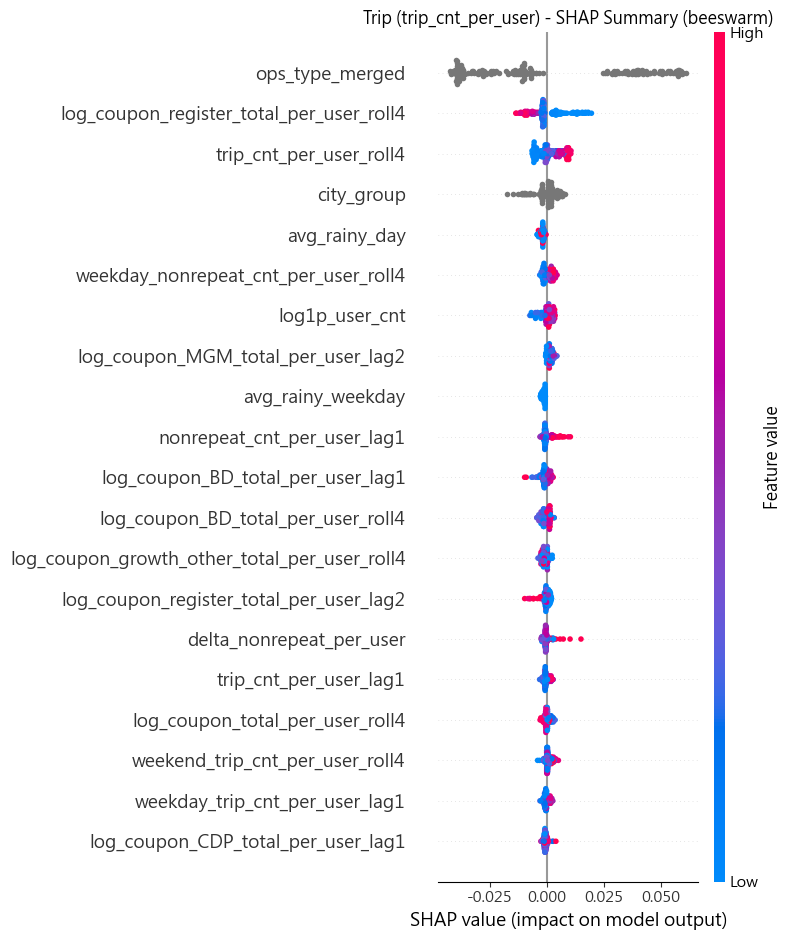

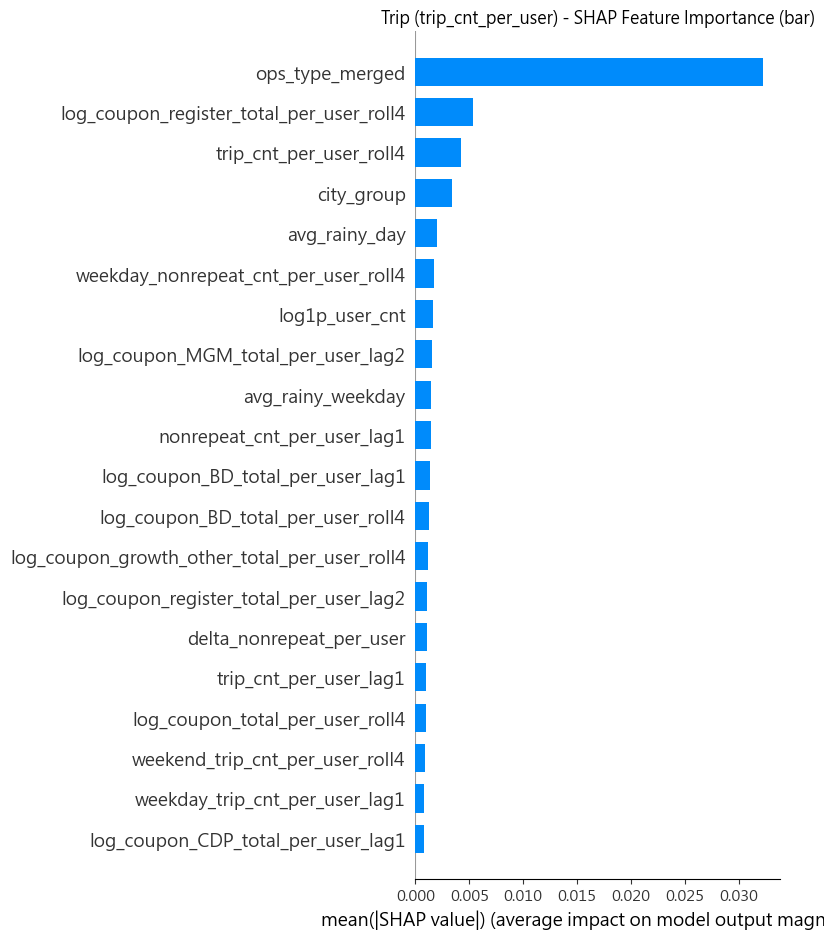

c:\Users\minhsiang.chang\AppData\Local\Programs\Python\Python312\Lib\site-packages\shap\plots\_waterfall.py:279: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Microsoft JhengHei.
  text_bbox = txt_obj.get_window_extent(renderer=renderer)


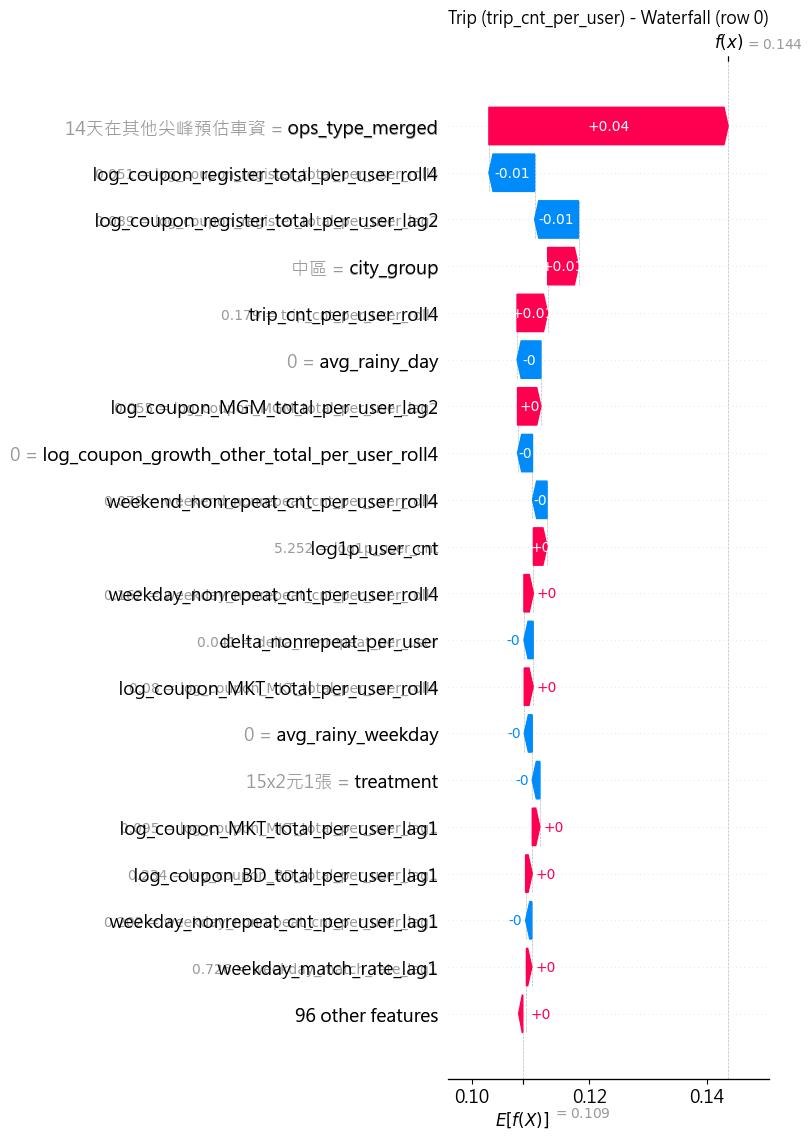

<Figure size 640x480 with 0 Axes>

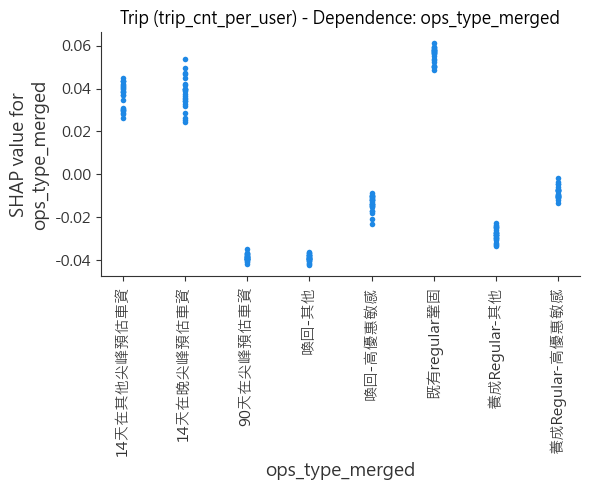

<Figure size 640x480 with 0 Axes>

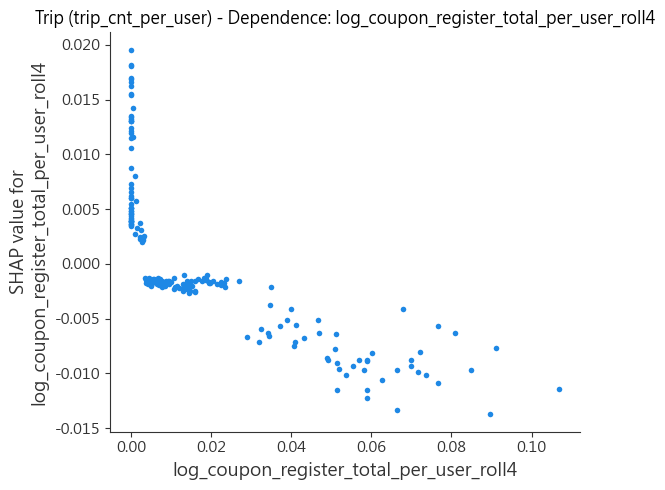

<Figure size 640x480 with 0 Axes>

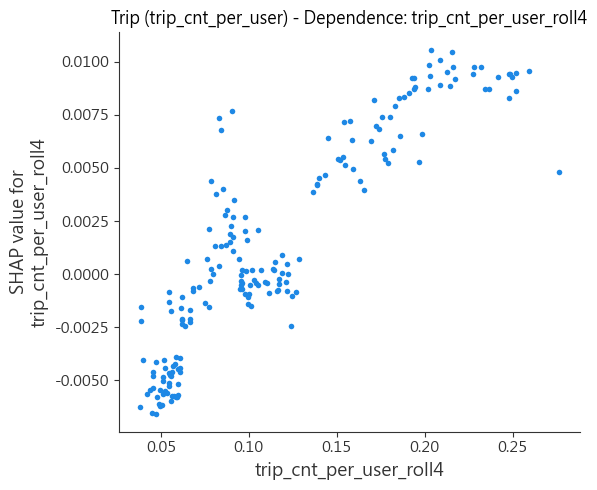

<Figure size 640x480 with 0 Axes>

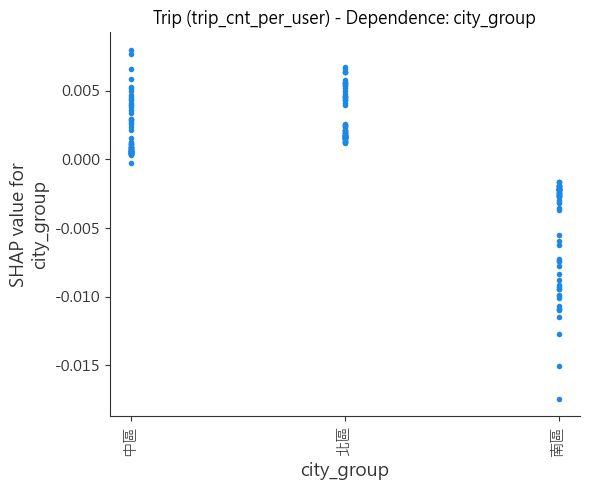

<Figure size 640x480 with 0 Axes>

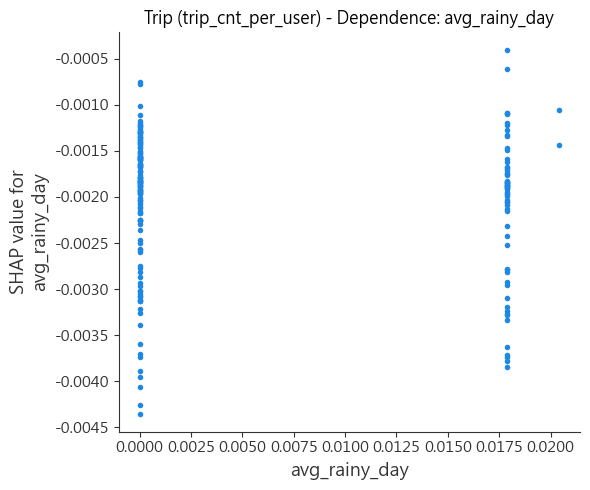

<Figure size 640x480 with 0 Axes>

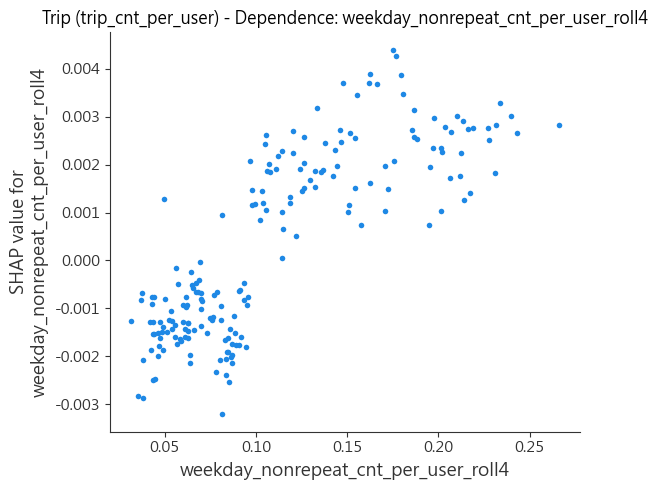


=== Nonrepeat (nonrepeat_cnt_per_user) | Top 20 features by mean(|SHAP|) ===
                                     feature  mean_abs_shap
                             ops_type_merged       0.042812
                               avg_rainy_day       0.006452
                                  city_group       0.006191
    log_coupon_register_total_per_user_roll4       0.004115
                nonrepeat_cnt_per_user_roll4       0.003632
          log_coupon_MGM_total_per_user_lag2       0.003054
                     trip_cnt_per_user_roll4       0.002977
                           avg_rainy_weekday       0.002811
log_coupon_growth_other_total_per_user_roll4       0.002699
                 nonrepeat_cnt_per_user_lag1       0.002077
        weekday_nonrepeat_cnt_per_user_roll4       0.001544
           log_coupon_BD_total_per_user_lag1       0.001511
                              log1p_user_cnt       0.001485
              weekday_trip_cnt_per_user_lag1       0.001477
     log_coupon_regist

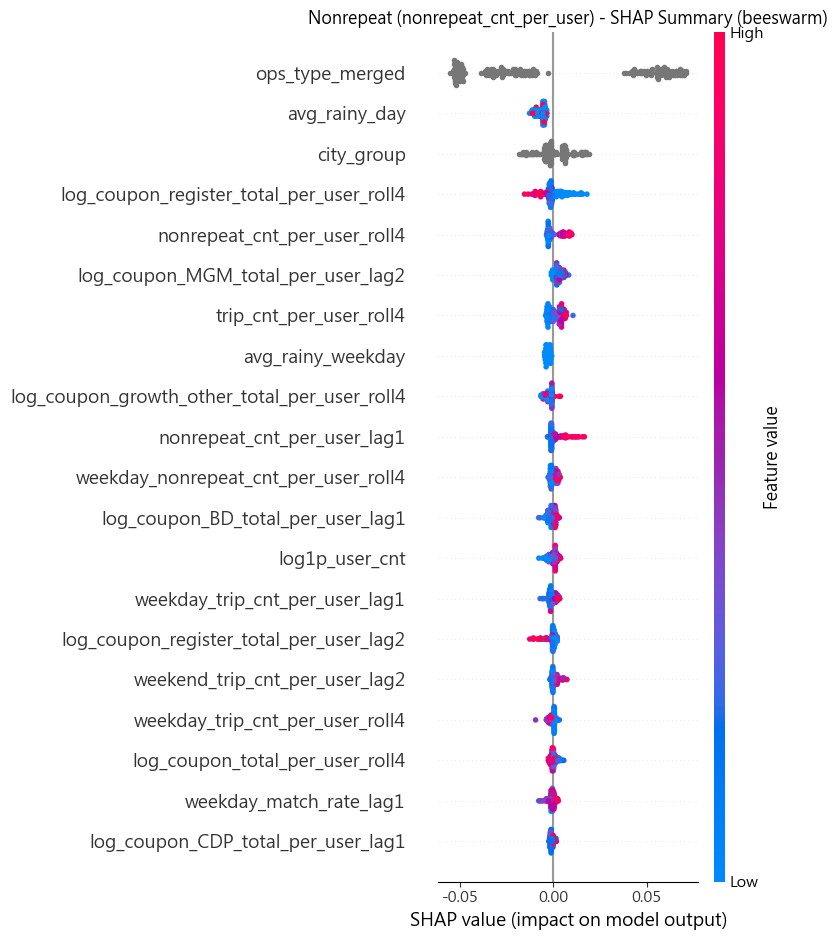

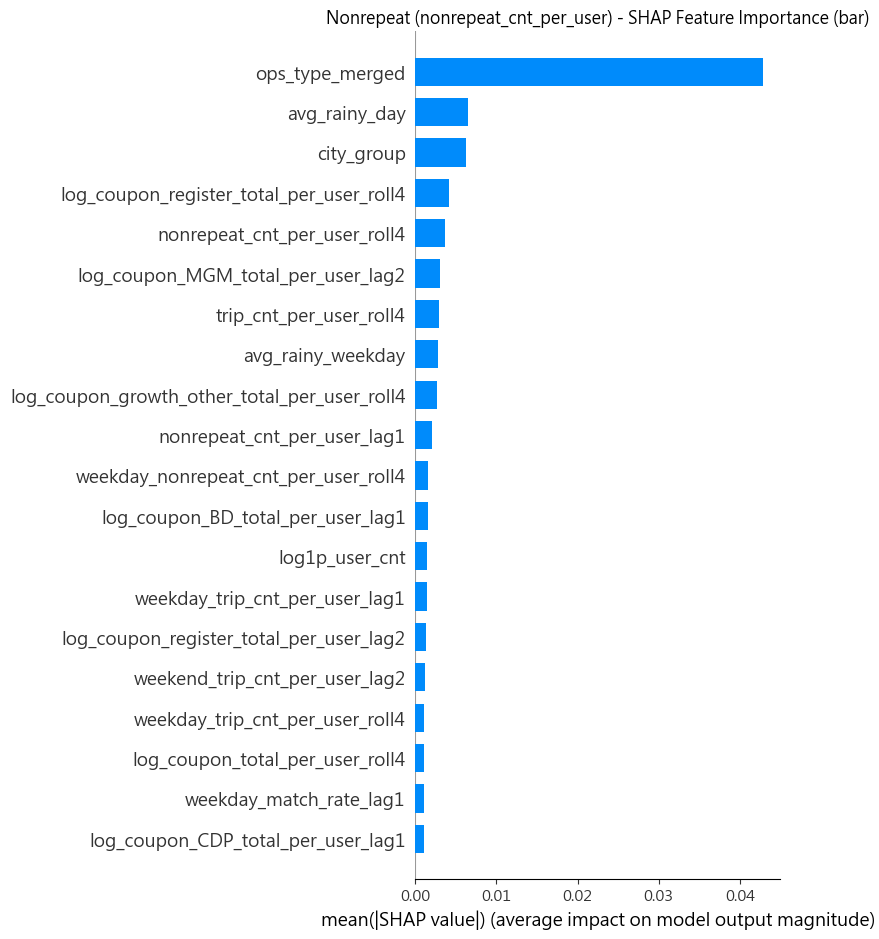

c:\Users\minhsiang.chang\AppData\Local\Programs\Python\Python312\Lib\site-packages\shap\plots\_waterfall.py:279: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Microsoft JhengHei.
  text_bbox = txt_obj.get_window_extent(renderer=renderer)


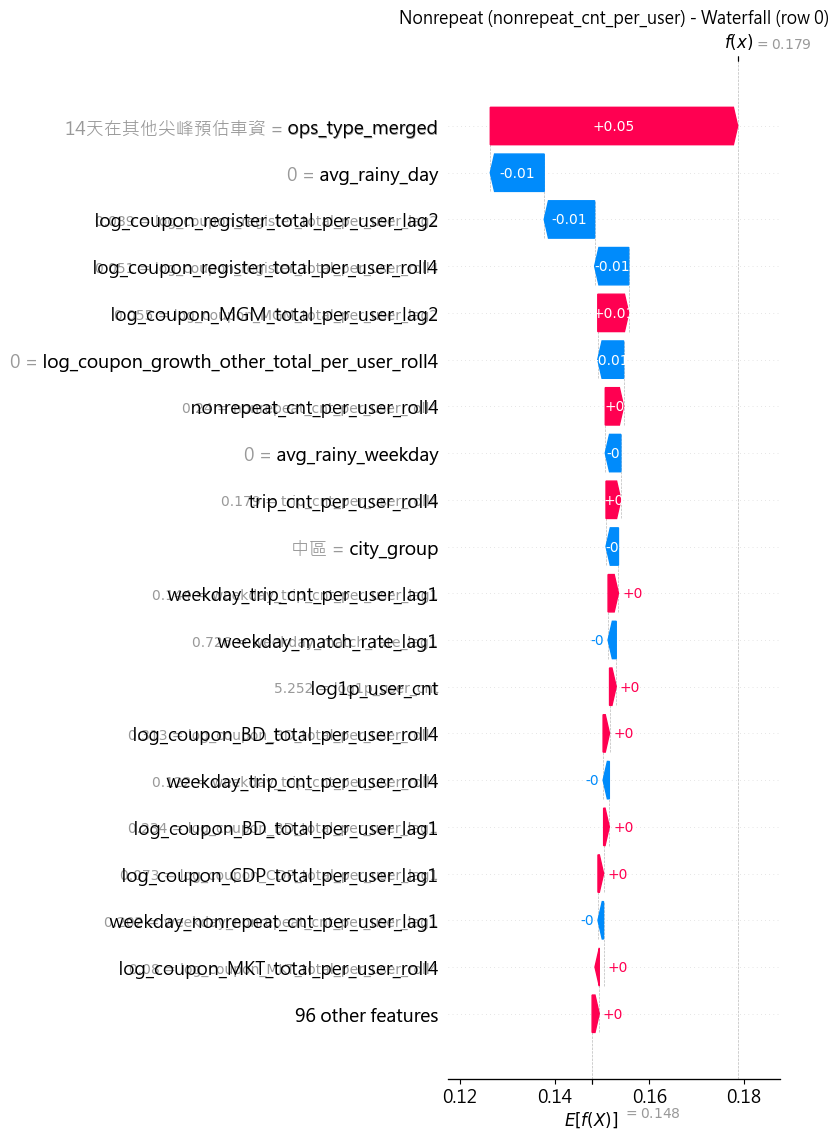

<Figure size 640x480 with 0 Axes>

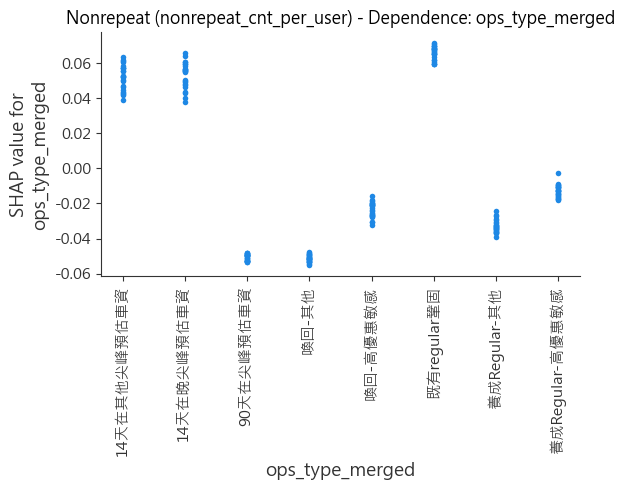

<Figure size 640x480 with 0 Axes>

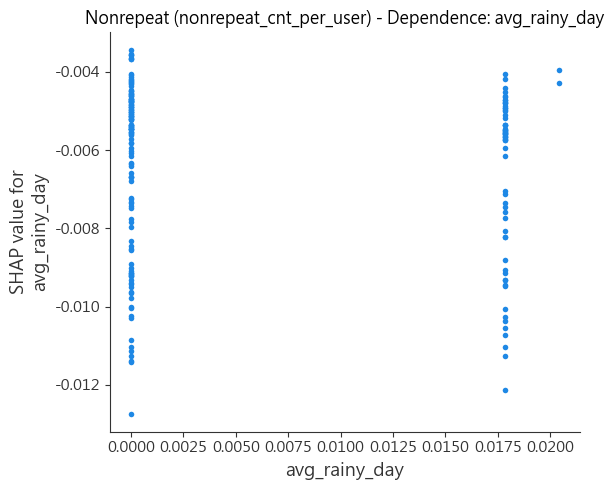

<Figure size 640x480 with 0 Axes>

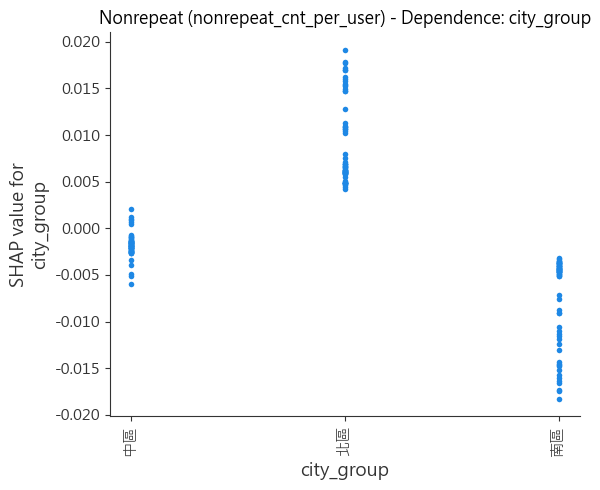

<Figure size 640x480 with 0 Axes>

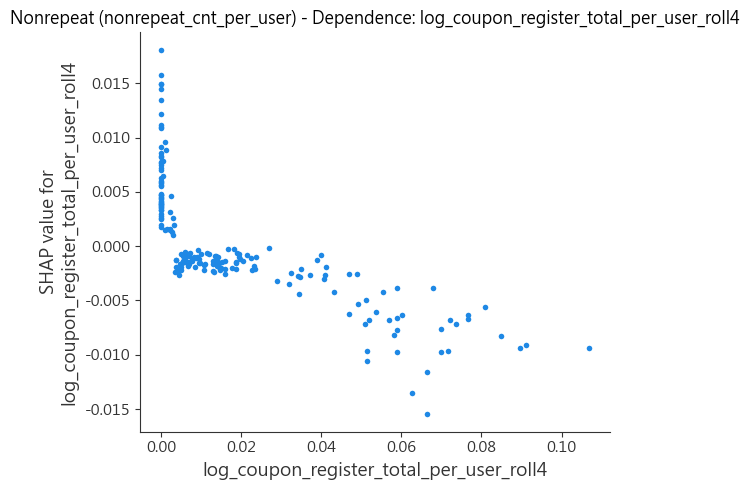

<Figure size 640x480 with 0 Axes>

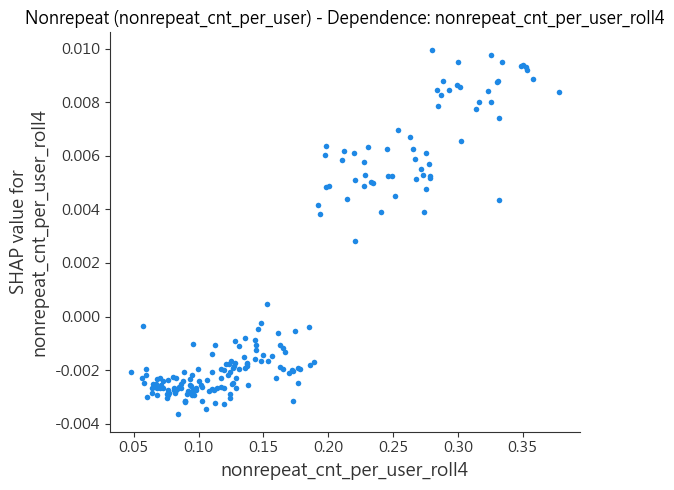

<Figure size 640x480 with 0 Axes>

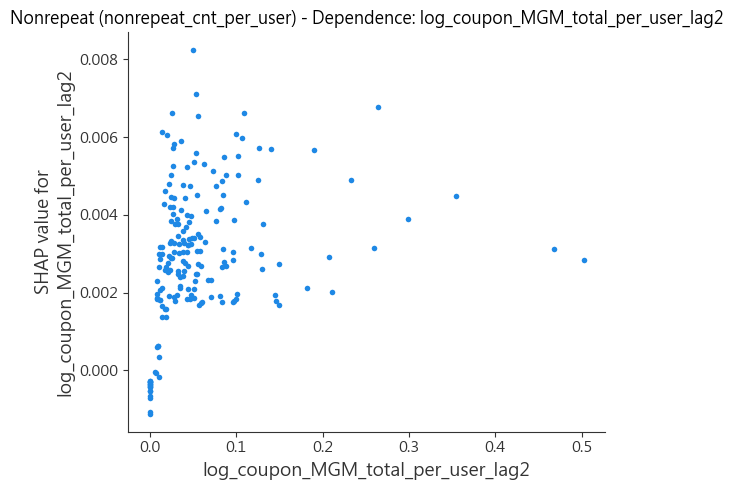


Done SHAP.


In [17]:
# ==========================================
# SHAP interpretation for ONE target week (2026-01-05)
# Global LGBM models:
#   - trip_cnt_per_user
#   - nonrepeat_cnt_per_user
#
# Outputs:
#   - mean(|SHAP|) feature importance (table)
#   - SHAP summary (beeswarm) + bar plot
#   - Waterfall plot for one chosen row
#   - Dependence plots for top features
#
# No file outputs. Only prints & plots.
# ==========================================

import numpy as np
import pandas as pd

# --------------------------
# Config
# --------------------------
DATA_PATH = "../../final_data/data_260119_random.csv"   # 改成你本機路徑也可以
DATE_COL = "experiment_date"
TARGET_WEEK = "2026-01-05"

CAT_COLS = ["treatment", "source", "ops_type_merged", "city_group"]

Y_TRIP = "trip_cnt_per_user"
Y_NONR = "nonrepeat_cnt_per_user"

RANDOM_STATE = 42
N_VAL_WEEKS = 4
EARLY_STOPPING_ROUNDS = 100

# How many rows to use for SHAP computation (speed control)
# 你 test 週目前是 192 rows，其實全算 OK；如果未來更大可調小
MAX_SHAP_ROWS = 1000

# Waterfall plot: choose which row index in test set (0-based after filtering target week)
WATERFALL_ROW_IDX = 0

# How many top features to show/plot
TOPK = 20
N_DEP_PLOTS = 6  # number of dependence plots for top features


# --------------------------
# Helpers
# --------------------------
def make_time_val_split(train_df, date_col, n_val_weeks=4):
    """
    用 train 內最後 n_val_weeks 個 unique 週當 validation（時間切分）
    """
    uniq_dates = np.array(sorted(pd.to_datetime(train_df[date_col]).dt.date.unique()))
    if len(uniq_dates) <= 2:
        return train_df.copy(), None

    n_val_weeks = min(n_val_weeks, max(1, len(uniq_dates) // 5))
    val_dates = set(uniq_dates[-n_val_weeks:])

    tr = train_df[~pd.to_datetime(train_df[date_col]).dt.date.isin(val_dates)].copy()
    va = train_df[pd.to_datetime(train_df[date_col]).dt.date.isin(val_dates)].copy()

    if tr.empty or va.empty:
        return train_df.copy(), None
    return tr, va


# --------------------------
# Load & preprocess
# --------------------------
df = pd.read_csv(DATA_PATH)
df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors="coerce")

if df[DATE_COL].isna().any():
    bad = df[df[DATE_COL].isna()].head(10)
    raise ValueError(f"Found unparsable dates in {DATE_COL}. Examples:\n{bad}")

required = CAT_COLS + [DATE_COL, Y_TRIP, Y_NONR]
missing = [c for c in required if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}")

for c in CAT_COLS:
    df[c] = df[c].astype("category")

# 用 week_idx 當時間特徵（避免直接餵日期）
min_date = df[DATE_COL].min()
df["week_idx"] = ((df[DATE_COL] - min_date).dt.days // 7).astype(int)

target_ts = pd.to_datetime(TARGET_WEEK)

train = df[df[DATE_COL] < target_ts].copy()
test  = df[df[DATE_COL] == target_ts].copy()

if train.empty:
    raise ValueError("Train set empty. TARGET_WEEK too early?")
if test.empty:
    raise ValueError(f"Test set empty for {TARGET_WEEK}.")

print(f"Target week: {TARGET_WEEK}")
print("Train rows:", len(train), "| Train weeks:", train[DATE_COL].dt.date.nunique())
print("Test  rows:", len(test),  "| Test  weeks:", test[DATE_COL].dt.date.nunique())

# Feature columns = everything except targets, and drop raw date
exclude = {Y_TRIP, Y_NONR}
feature_cols = [c for c in df.columns if c not in exclude]
if DATE_COL in feature_cols:
    feature_cols.remove(DATE_COL)

cat_features = [c for c in CAT_COLS if c in feature_cols]


# --------------------------
# Train two LGBM models (trip, nonrepeat)
# --------------------------
import lightgbm as lgb

params = dict(
    objective="regression",
    n_estimators=2000,
    learning_rate=0.05,
    num_leaves=63,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RANDOM_STATE,
    force_row_wise=True,
)

tr_df, va_df = make_time_val_split(train, DATE_COL, n_val_weeks=N_VAL_WEEKS)

X_tr = tr_df[feature_cols].copy()
y_tr_trip = tr_df[Y_TRIP].astype(float).values
y_tr_nonr = tr_df[Y_NONR].astype(float).values

X_va = y_va_trip = y_va_nonr = None
if va_df is not None:
    X_va = va_df[feature_cols].copy()
    y_va_trip = va_df[Y_TRIP].astype(float).values
    y_va_nonr = va_df[Y_NONR].astype(float).values

X_train_all = train[feature_cols].copy()
y_train_trip = train[Y_TRIP].astype(float).values
y_train_nonr = train[Y_NONR].astype(float).values

X_test = test[feature_cols].copy()

fit_kwargs = dict(categorical_feature=cat_features)

m_trip = lgb.LGBMRegressor(**params)
m_nonr = lgb.LGBMRegressor(**params)

if X_va is not None:
    m_trip.fit(
        X_tr, y_tr_trip,
        eval_set=[(X_va, y_va_trip)],
        eval_metric="l2",
        callbacks=[lgb.early_stopping(stopping_rounds=EARLY_STOPPING_ROUNDS, verbose=False)],
        **fit_kwargs
    )
    m_nonr.fit(
        X_tr, y_tr_nonr,
        eval_set=[(X_va, y_va_nonr)],
        eval_metric="l2",
        callbacks=[lgb.early_stopping(stopping_rounds=EARLY_STOPPING_ROUNDS, verbose=False)],
        **fit_kwargs
    )
else:
    m_trip.fit(X_train_all, y_train_trip, **fit_kwargs)
    m_nonr.fit(X_train_all, y_train_nonr, **fit_kwargs)

print("\nModels trained.")
print("Trip best_iteration_:", getattr(m_trip, "best_iteration_", None))
print("Nonrepeat best_iteration_:", getattr(m_nonr, "best_iteration_", None))

# --------------------------
# SHAP
# --------------------------
# If you don't have shap:
#   pip install shap
import shap
import matplotlib.pyplot as plt

# Speed control: subsample rows for SHAP if very large
X_shap = X_test.copy()
if len(X_shap) > MAX_SHAP_ROWS:
    X_shap = X_shap.sample(MAX_SHAP_ROWS, random_state=RANDOM_STATE).copy()

# IMPORTANT:
# SHAP with categorical features in LGBM usually works with pandas category dtype.
# If you run into errors, a common workaround is to cast category to string before SHAP:
#   for c in cat_features: X_shap[c] = X_shap[c].astype(str)
# But keep it consistent with X_test you pass in.
#
# We'll try direct first.

def run_shap_for_model(model, X_background, X_explain, title_prefix):
    """
    Compute and plot SHAP:
      - importance table (mean abs SHAP)
      - summary beeswarm
      - bar plot
      - waterfall for one row
      - dependence plots for top features
    """
    # For Tree models, TreeExplainer is appropriate
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_explain)

    # shap_values shape: (n_samples, n_features)
    sv = np.array(shap_values)
    if sv.ndim != 2:
        raise ValueError(f"Unexpected shap_values shape: {sv.shape}")

    # Global importance: mean absolute shap
    mean_abs = np.mean(np.abs(sv), axis=0)
    imp = pd.DataFrame({
        "feature": X_explain.columns,
        "mean_abs_shap": mean_abs
    }).sort_values("mean_abs_shap", ascending=False)

    print(f"\n=== {title_prefix} | Top {TOPK} features by mean(|SHAP|) ===")
    print(imp.head(TOPK).to_string(index=False))

    # Summary plot (beeswarm)
    plt.figure()
    shap.summary_plot(sv, X_explain, show=False, max_display=TOPK)
    plt.title(f"{title_prefix} - SHAP Summary (beeswarm)")
    plt.tight_layout()
    plt.show()

    # Bar plot
    plt.figure()
    shap.summary_plot(sv, X_explain, plot_type="bar", show=False, max_display=TOPK)
    plt.title(f"{title_prefix} - SHAP Feature Importance (bar)")
    plt.tight_layout()
    plt.show()

    # Waterfall for one row
    row_idx = min(WATERFALL_ROW_IDX, len(X_explain) - 1)
    base_value = explainer.expected_value
    # shap.Explanation is the modern API for waterfall
    explanation = shap.Explanation(
        values=sv[row_idx, :],
        base_values=base_value,
        data=X_explain.iloc[row_idx, :],
        feature_names=X_explain.columns.tolist()
    )

    plt.figure()
    shap.plots.waterfall(explanation, max_display=20, show=False)
    plt.title(f"{title_prefix} - Waterfall (row {row_idx})")

    # 針對整張圖修復負號方框
    fix_shap_minus_in_figure(plt.gcf(), force_numeric_font=True)

    plt.tight_layout()
    plt.show()

    # Dependence plots for top features (directionality)
    top_features = imp["feature"].head(min(N_DEP_PLOTS, len(imp))).tolist()
    for f in top_features:
        plt.figure()
        shap.dependence_plot(f, sv, X_explain, show=False, interaction_index=None)
        plt.title(f"{title_prefix} - Dependence: {f}")
        plt.tight_layout()
        plt.show()

    return imp

# Run SHAP for each target model
imp_trip = run_shap_for_model(m_trip, X_train_all, X_shap, "Trip (trip_cnt_per_user)")
imp_nonr = run_shap_for_model(m_nonr, X_train_all, X_shap, "Nonrepeat (nonrepeat_cnt_per_user)")

print("\nDone SHAP.")
